In [10]:
import matplotlib.pyplot as plt
import numpy as np
import cmath
from scipy.interpolate import griddata
from IPython.display import Image
%matplotlib inline
plt.rc('text', usetex=True)
plt.rc('font', size=22)
plt.gcf().tight_layout()

pi=np.pi

<Figure size 432x288 with 0 Axes>

# Problem 1

## The residual error measures how well the discretized solution satisfies the discretized equation and hence given by $r=f-L\phi$. The true error measures how well the discretised solution approximates the true solution. True error is given by $\phi^{true}-\phi_{i,j}$. Both should ideally become zero for a continuous problem.

# Problem2

In [20]:
def jacobi(tol):
    #Making mesh
    nt=2**7
    delxy=1/nt
    t=np.arange(0,1,delxy)
    xt, yt = np.meshgrid(t, t)

    #Forcing function
    f= 8.0*pi**2*np.cos(4.0*pi*yt)*(np.cos(4.0*pi*xt) - \
            np.sin(4.0*pi*xt)) - \
            16.0*pi**2*(np.sin(4.0*pi*xt)*np.cos(2.0*pi*yt)**2 + \
            np.sin(2.0*pi*xt)**2 * np.cos(4.0*pi*yt))

    #Solution initialization
    phi=np.zeros_like(xt)
    Aphi=np.sin(2*np.pi*xt)**2*np.cos(4*np.pi*yt) \
        +np.sin(4*np.pi*xt)*np.cos(2*np.pi*yt)**2
    #Setting max Iteration
    imax=10000
    error=[]
    it=[]
    for i in range(imax):
        phi=0.25*(np.roll(phi,1,axis=0)+np.roll(phi,-1,axis=0)\
                  +np.roll(phi,1,axis=1)+np.roll(phi,-1,axis=1)\
                 -delxy**2*f)
        res= f-(np.roll(phi,1,axis=0)+np.roll(phi,-1,axis=0)\
                    +np.roll(phi,1,axis=1)+np.roll(phi,-1,axis=1)\
                    -4*phi)/delxy**2
        
        error=np.append(error,np.linalg.norm(phi-Aphi))
        it=np.append(it,i)

        if (np.linalg.norm(res)<tol*np.linalg.norm(f)):
            #print ('Convergence at',i,'iteration')
            break

    #plt.pcolormesh(t,t,phi.real)
    #plt.colorbar()
    #plt.show()
    return i,it,error

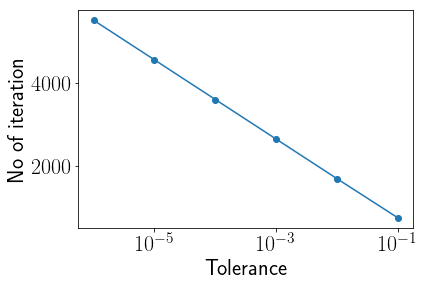

In [21]:
ntol= 10**np.linspace(-1,-6,6)
niter=np.zeros_like(ntol)
for n,tol in enumerate(ntol):
    niter[n],_,_=jacobi(tol)
plt.semilogx(ntol, niter,'-o')
plt.xlabel('Tolerance')
plt.ylabel('No of iteration')
plt.show()

# Problem 3

## In multi-grid methods, we reduce the mesh size to get rid of large wavelength error. Since it helps in quick information travel along the domain, the number of iterations requred to converge reduces.

# Problem 4

For simplicity, the number of points in one direction (x or y) is taken as $n=2^x$. For eg $n=256$ ($x=8$) would be the fine mesh. The coarse mesh would be having $x=5$. The intermediate meshes would have $x=7,6$.  

Final Convergence at 915 Cylces


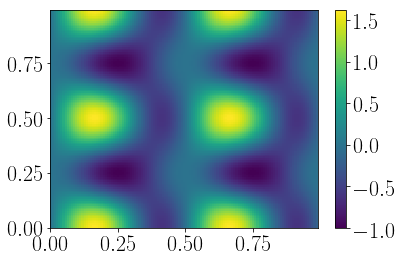

In [32]:
def restrict(fine,nc):
    return fine.reshape(nc,2,nc,2).mean(axis=3).mean(1)

def prolong(coarse,nf):
    mx=0.5*(np.roll(coarse,-1,axis=1)-np.roll(coarse,1,axis=1))
    my=0.5*(np.roll(coarse,-1,axis=0)-np.roll(coarse,1,axis=0))
    nc=coarse.shape[0]
    phic=np.zeros([nf,nf])
    phic[::2,::2]=coarse-0.25*mx-0.25*my
    phic[1::2,::2]=coarse+0.25*mx-0.25*my
    phic[::2,1::2]=coarse-0.25*mx+0.25*my
    phic[1::2,1::2]=coarse+0.25*mx+0.25*my
#    for i in range(nc):
#        for j in range(nc):
#            phic[2*j:2*(j+1),2*i:2*(i+1)]=coarse[j][i]*np.identity(2)\
#            +0.25*mx[j][i]*np.array([[-1,1],[-1,1]])+0.25*my[j][i]*np.array([[1,1],[-1,-1]])
    return phic
        
    return
def frhs(xt,yt):
    return 8.0*pi**2*np.cos(4.0*pi*yt)*(np.cos(4.0*pi*xt) - \
        np.sin(4.0*pi*xt)) - \
        16.0*pi**2*(np.sin(4.0*pi*xt)*np.cos(2.0*pi*yt)**2 + \
        np.sin(2.0*pi*xt)**2 * np.cos(4.0*pi*yt))

def jacobisolve(xt,yt,phi,imax=1000,tol=1e-6):
    delxy=xt[0][1]-xt[0][0]
    f=frhs(xt,yt)
    
    for i in range(imax):
        phi=0.25*(np.roll(phi,1,axis=0)+np.roll(phi,-1,axis=0)\
                  +np.roll(phi,1,axis=1)+np.roll(phi,-1,axis=1)\
                 -delxy**2*f)
        res= f-(np.roll(phi,1,axis=0)+np.roll(phi,-1,axis=0)\
                    +np.roll(phi,1,axis=1)+np.roll(phi,-1,axis=1)\
                    -4*phi)/delxy**2

        if (np.linalg.norm(res)<tol*np.linalg.norm(f)):
            #print ('Convergence at',i,'iteration')
            break
    return phi,res

def ressolve(xt,yt,res,imax=1000,tol=1e-6):
    delxy=xt[0][1]-xt[0][0]
    err= np.zeros_like(res)
    for i in range(imax):
        err=0.25*(np.roll(err,1,axis=0)+np.roll(err,-1,axis=0)\
                  +np.roll(err,1,axis=1)+np.roll(err,-1,axis=1)\
                 -delxy**2*res)
        resres= res-(np.roll(err,1,axis=0)+np.roll(err,-1,axis=0)\
                    +np.roll(err,1,axis=1)+np.roll(err,-1,axis=1)\
                    -4*err)/delxy**2

        if (np.linalg.norm(resres)<tol*np.linalg.norm(res)):
            #print ('Coarse Convergence at',i,'iteration')
            break
    return err,resres

#Finest mesh
x=7
nf=2**x
tf=np.arange(0,1,1/nf)
xf, yf = np.meshgrid(tf, tf)
    
#intermediate and coarse mesh
ni1,ni2,nc= 2**np.array([x-1,x-2,x-3])
xi1=restrict(xf,ni1)
yi1=restrict(yf,ni1)
xi2=restrict(xi1,ni2)
yi2=restrict(yi1,ni2)
xc=restrict(xi2,nc)
yc=restrict(yi2,nc)

phif=np.zeros_like(xf)
tol= 10**(-6)

error=[]
it=[]

#First 10 iterations in fine mesh
phif,resf= jacobisolve(xf,yf,phif,10)
imax=100000
for i in range(imax):
    
    #Intermediate mesh1
    resi1= restrict(resf,ni1)
    erri1,resi1=ressolve(xi1,yi1,resi1,3)
    
    #Intermediate mesh2
    resi2= restrict(resi1,ni2)
    erri2,resi2=ressolve(xi2,yi2,resi2,100000,1e-4)
    
    #Back to intermediate mesh 1
    resi1= prolong(erri2,ni1)+resi1
    erri1,resi1=ressolve(xi1,yi1,resi1,3)
    
    #Back to finest mesh
    resf= prolong(erri1,nf)+resf
    errf,resf =ressolve(xf,yf,resf,3)
    phif=phif+errf
    
    [phif,resf]= jacobisolve(xf,yf,phif,3)
    
    error= np.append(error,np.linalg.norm(errf))
    it=np.append(it,i)
    
    if (np.linalg.norm(resf)<tol*np.linalg.norm(frhs(xf,yf))):
        print ('Final Convergence at',i,'Cylces')
        break

plt.pcolormesh(tf,tf,phif)
plt.colorbar()
plt.show()

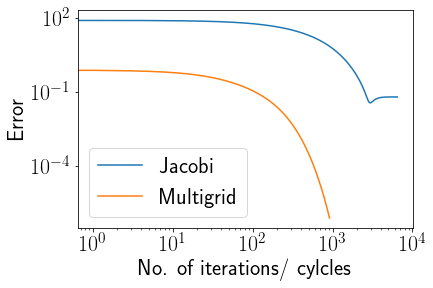

In [35]:
_,jacobi_it,jacobi_error=jacobi(1e-7)
plt.loglog(jacobi_it,jacobi_error,label='Jacobi')
plt.loglog(it,error,label='Multigrid')
plt.legend()
plt.xlabel('No. of iterations/ cylcles')
plt.ylabel('Error')
plt.show()